In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
import numpy as np
import pickle
import pprint # Pretty Printer!
import warnings
import statistics

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
obs_path = "C:/Users/ilebe/Documents/!Masters!/Analysis/0. Data/Processed/All Processed Final Location"
covariates_path = "C:/Users/ilebe/Documents/!Masters!/Analysis/0. Data/Processed/covariates"
get_rid_of_these_sites_retn_too_large = ["H23-RS-167", "H-RS-1-98", "H23-RS-109"]
mean_var_figure_path = r"C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Output\Mean and variance"

In [3]:
# truncated_100m_counts = pd.read_csv(os.path.join(obs_path, "Truncated_100m_count_per_site_filtered.csv"))
truncated_100m_counts = pd.read_csv(os.path.join(obs_path, "Truncated_100m_count_per_site_filtered FIXED.csv"))
truncated_150m_counts = pd.read_csv(os.path.join(obs_path, "Truncated_150m_count_per_site_filtered FIXED.csv"))
truncated_250m_counts = pd.read_csv(os.path.join(obs_path, "Truncated_250m_count_per_site_filtered FIXED.csv"))
counts = pd.read_csv(os.path.join(obs_path, "count_per_site_filtered.csv")) # this is unlimited

In [4]:
number_of_visits_per_site = pd.read_csv(os.path.join(obs_path, "number_of_transcribed_recordings_per_site.csv"))
list_of_sites_to_use = number_of_visits_per_site[number_of_visits_per_site['number_of_visits'] >= 10]['location'].to_list()

list_of_sites_to_use.remove("H23-RS-167")
list_of_sites_to_use.remove("H-RS-1-98")
list_of_sites_to_use.remove("H23-RS-109")

In [5]:
warnings.filterwarnings('ignore')
truncCounts250_10vis = truncated_250m_counts[truncated_250m_counts['location'].isin(list_of_sites_to_use)]
truncCounts250_10vis.sort_values('location', inplace=True)

truncCounts150_10vis = truncated_150m_counts[truncated_150m_counts['location'].isin(list_of_sites_to_use)]
truncCounts150_10vis.sort_values('location', inplace=True)

truncCounts100_10vis = truncated_100m_counts[truncated_100m_counts['location'].isin(list_of_sites_to_use)]
truncCounts100_10vis.sort_values('location', inplace=True)

unlimitedCounts_10vis = counts[counts['location'].isin(list_of_sites_to_use)]
unlimitedCounts_10vis.sort_values('location', inplace=True)

# A. Mean to variacne ratio

In [6]:
def get_max_count(dataframe, bird):
    obs_count_10 = dataframe 
    sites_with_10_or_more_visits = obs_count_10['location'].value_counts() >= 10
    sites_to_consider = sites_with_10_or_more_visits[sites_with_10_or_more_visits].index

    filtered_obs_count = obs_count_10[obs_count_10['location'].isin(sites_to_consider)]

    # Subsample to exactly 10 visits per site
    final_obs_count = filtered_obs_count.groupby('location').apply(lambda x: x.sample(n=10, replace=False, random_state = 123)).reset_index(drop=True)
    final_obs_count['visit_number'] = final_obs_count.groupby('location').cumcount() + 1
    N_matrix_visit_num = final_obs_count.pivot(index='location', columns='visit_number', values=f"{bird}").fillna(0).astype(int).values.tolist()

    # Calculate the maximum count encountered at each site
    max_counts = [max(site_counts) for site_counts in N_matrix_visit_num]
    return max_counts

dist_dict = {'100m': truncCounts100_10vis, '150m': truncCounts150_10vis, '250m': truncCounts250_10vis, 'unlimited': unlimitedCounts_10vis}
dist_list = [truncCounts100_10vis, truncCounts150_10vis, truncCounts250_10vis, unlimitedCounts_10vis]

OSFL_mean_var_dict = {}
for distance, dist_df in dist_dict.items():
    mean = statistics.mean(get_max_count(dist_df, 'OSFL'))
    variance = statistics.variance(get_max_count(dist_df, 'OSFL'))
    ratio = mean/variance
    OSFL_mean_var_dict[distance] = [mean, variance, ratio]


OSFL_mean_var_df = pd.DataFrame.from_dict(OSFL_mean_var_dict, orient = 'index', columns = ['mean', 'variance', 'ratio'])
OSFL_mean_var_df

,mean,variance,ratio
100m,0.033163,0.037261,0.890037
150m,0.040816,0.039250,1.039894
250m,0.132653,0.130696,1.014976
unlimited,0.183673,0.237278,0.774087


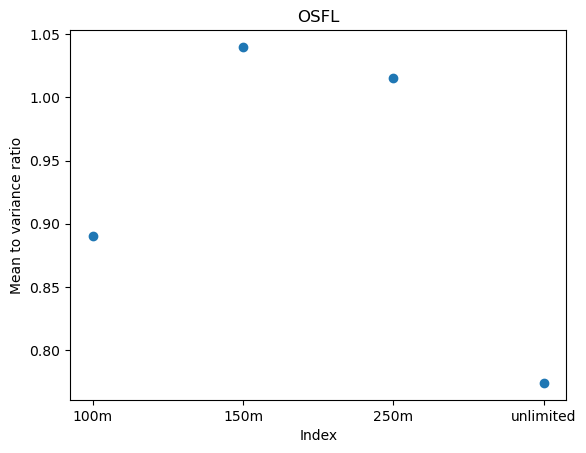

In [7]:
# Plotting
# OSFL_mean_var_df['ratio'].plot(kind='scatter')
plt.scatter(range(len(OSFL_mean_var_df.index)), OSFL_mean_var_df['ratio'])

# Customizing the plot
plt.xticks(range(len(OSFL_mean_var_df.index)), OSFL_mean_var_df.index) # Set x-ticks to index values
plt.title('OSFL')
plt.ylabel('Mean to variance ratio')
plt.xlabel('Index')
plt.show()
# plt.savefig()


# B. Detection probailities

$$
P_{\text{detection}}(site) = \frac{N_{\text{visits with detections}}}{N_{\text{total visits}}}
$$

$$P_{\text{average detection}} = \frac{\sum_{i=1}^{n} P_{\text{detection}}(site_i)}{n}$$

In [1]:
# Reading the obs_count_10.csv file
obs_count_10 = truncCounts150_10vis
# obs_count_10 = truncCounts250_10vis
# obs_count_10 = unlimitedCounts_10vis
# Filter out sites with less than 10 visits
sites_with_10_or_more_visits = obs_count_10['location'].value_counts() >= 10
sites_to_consider = sites_with_10_or_more_visits[sites_with_10_or_more_visits].index

filtered_obs_count = obs_count_10[obs_count_10['location'].isin(sites_to_consider)]
# For each site, calculate the detection probability
site_list = list(filtered_obs_count['location'].unique())
# detection_probs = len(site_list)
# detection_probs = {}
detection_probs = []
bird = 'OSFL'
for site in site_list:
    total_visits = filtered_obs_count.loc[filtered_obs_count['location'] == site].shape[0]
    # print(total_visits)
    detection_visits = filtered_obs_count.loc[filtered_obs_count['location'] == site].loc[filtered_obs_count[bird] >= 1].shape[0]
    # print(detection_visits)
    detection_probs.append(detection_visits/total_visits)
# print(detection_probs)
average_detection_prob = sum(detection_probs)/len(detection_probs)
print(average_detection_prob)
    

NameError: name 'truncCounts150_10vis' is not defined

In [ ]:
p = average_detection_prob
d = 0.1
def required_visits(p, d):
    return math.ceil(math.log(d) / math.log(1-p))

In [ ]:
visits = required_visits(p, d)
print(visits)